In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [3]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/sg_clahe.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/CLAHE/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/CLAHE/val'

NUM_MODELS = 3
SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 16

### Load Base Classifiers

In [5]:
def changeLayerName(model,model_prefix):
    for layer in model.layers:
        layer._name = model_prefix+'_'+layer.name
        layer.trainable = False
    return model

In [6]:
TRAINING_DIR = '/home/Training'
effnet_path = os.path.join(TRAINING_DIR,'EfficientNet/weights','efficientnet_clahe.hdf5')
chexnet_path = os.path.join(TRAINING_DIR,'ChexNet/weights','chexnet_clahe.hdf5')
squeezenet_path = os.path.join(TRAINING_DIR,'SqueezeNet/weights','squeezenet_clahe.hdf5')

effnet_model = tf.keras.models.load_model(effnet_path)
effnet_model._name="EfficientNet"
effnet_model = changeLayerName(effnet_model,'effnet')

chexnet_model = tf.keras.models.load_model(chexnet_path)
chexnet_model._name="ChexNet"
chexnet_model = changeLayerName(chexnet_model,'chexnet')

squeezenet_model = tf.keras.models.load_model(squeezenet_path)
squeezenet_model._name="SqueezeNet"
squeezenet_model = changeLayerName(squeezenet_model,'snet')

2022-08-16 18:28:44.904346: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-16 18:28:44.904416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


#### Extract Features from base classifiers

In [7]:
# SqueezeNet Features. Average pooling to make it (7X7X1000)
squeezenet_features = squeezenet_model.layers[-4].output
squeezenet_features = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding="same")(squeezenet_features)

eff_features = effnet_model.layers[-4].output
chexnet_features = chexnet_model.layers[-4].output

concatenated_features = tf.keras.layers.Concatenate(name='DeepConcatenatedFeatures')([eff_features, chexnet_features,squeezenet_features])

#### Create Model from Concatenated Features

In [8]:
x = tf.keras.layers.GlobalAveragePooling2D()(concatenated_features)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
y = tf.keras.layers.Dense(3, activation="softmax", kernel_initializer="he_normal")(x)
stacked_model = tf.keras.Model(inputs=[effnet_model.input,chexnet_model.input,squeezenet_model.input], outputs=y,name='StackedGeneralization')
stacked_model.summary()

Model: "StackedGeneralization"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 chexnet_input_1 (InputLayer)   [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 chexnet_zero_padding2d (ZeroPa  (None, 230, 230, 3)  0          ['chexnet_input_1[0][0]']        
 dding2D)                                                                                         
                                                                                                  
 chexnet_conv1/conv (Conv2D)    (None, 112, 112, 64  9408        ['chexnet_zero_padding2d[0][0]'] 
                                )                                             

In [ ]:
#Plot model
#tf.keras.utils.plot_model(stacked_model, to_file='./voting_ensemble.png', show_shapes=True)

#### Keras Callbacks

In [9]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(stacked_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(stacked_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    

checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=.1,
                             patience=15,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 9130 images belonging to 3 classes.
Found 2032 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.972310969116081, 1: 1.0144444444444445, 2: 1.0144444444444445}
samples for train class labels: dict_items([(0, 3130), (1, 3000), (2, 3000)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 923), (1, 800), (2, 309)])


#### Construct Multi-input Generators

In [11]:
def train_generator_func(generator):
    while True:
        x,Y = next(generator)
        X = [x,x,x]
        yield X,Y

def val_generator_func(generator):
    while True:
        x,Y = next(generator)
        X = [x,x,x]
        yield (X,Y)

#### EfficientNet Compilation and Execution

In [12]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
stacked_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [13]:
warnings.filterwarnings("ignore")
epochs = 20
history = stacked_model.fit(train_generator_func(train_generator),
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator_func(validation_generator),
                                validation_steps = len(validation_generator),
                                epochs=epochs,
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 1/20


2022-08-16 18:29:34.464468: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


571/571 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.9217 - AUC: 0.9869 - precision: 0.9519 - recall: 0.8915
Epoch 00001: val_loss improved from inf to 0.19593, saving model to ./weights/sg_clahe.hdf5
End of epoch 0. Learning rate: 1e-04
571/571 [==============================] - 155s 248ms/step - loss: 0.2755 - accuracy: 0.9217 - AUC: 0.9869 - precision: 0.9519 - recall: 0.8915 - val_loss: 0.1959 - val_accuracy: 0.9247 - val_AUC: 0.9896 - val_precision: 0.9289 - val_recall: 0.9188 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 2/20
571/571 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9724 - AUC: 0.9978 - precision: 0.9768 - recall: 0.9686
Epoch 00002: val_loss improved from 0.19593 to 0.17274, saving model to ./weights/sg_clahe.hdf5
End of epoch 1. Learning rate: 1e-04
571/571 [==============================] - 137s 240ms/step - loss: 0.0957 - accuracy: 0.9724 - AUC: 0.9978 - precision: 0.9768 - recall: 0.9686 - val_loss: 0.1727 - va

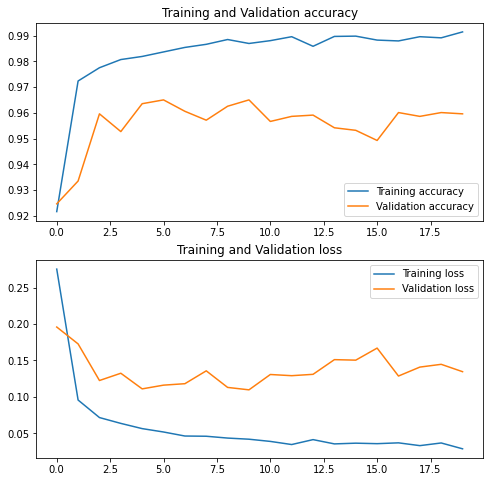

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.show()

In [15]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
9,0.041842,0.986966,0.998799,0.988047,0.986857,0.109653,0.965059,0.994803,0.966930,0.964075,0.0001
4,0.056396,0.981928,0.998588,0.983311,0.980942,0.110978,0.963583,0.995283,0.966370,0.961614,0.0001
8,0.043406,0.988499,0.998597,0.988707,0.987733,0.112991,0.962598,0.994790,0.963968,0.961122,0.0001
5,0.051751,0.983680,0.998834,0.984950,0.982037,0.116101,0.965059,0.994851,0.967343,0.962106,0.0001
6,0.046221,0.985433,0.998725,0.986823,0.984337,0.118092,0.960630,0.995354,0.962926,0.958661,0.0001
2,0.071576,0.977547,0.998307,0.981140,0.974370,0.122471,0.959646,0.995209,0.964817,0.958169,0.0001
16,0.036850,0.987952,0.999282,0.988376,0.987185,0.128612,0.960138,0.992708,0.960591,0.959646,0.0001
11,0.034524,0.989595,0.999096,0.990134,0.989266,0.129100,0.958661,0.993461,0.958600,0.957185,0.0001
10,0.038820,0.988061,0.999069,0.988923,0.987623,0.130727,0.956693,0.993184,0.959506,0.956201,0.0001


In [16]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
stacked_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [17]:
history_finetune = stacked_model.fit(train_generator_func(train_generator),
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator_func(validation_generator),
                                validation_steps = len(validation_generator),
                                epochs=30,
                                initial_epoch=history.epoch[-1],
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 20/30
571/571 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9901 - AUC: 0.9995 - precision: 0.9909 - recall: 0.9898
Epoch 00020: val_loss did not improve from 0.10965
End of epoch 19. Learning rate: 1e-05
571/571 [==============================] - 159s 260ms/step - loss: 0.0287 - accuracy: 0.9901 - AUC: 0.9995 - precision: 0.9909 - recall: 0.9898 - val_loss: 0.1362 - val_accuracy: 0.9592 - val_AUC: 0.9920 - val_precision: 0.9615 - val_recall: 0.9592 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 21/30
571/571 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9912 - AUC: 0.9996 - precision: 0.9917 - recall: 0.9908
Epoch 00021: val_loss did not improve from 0.10965
End of epoch 20. Learning rate: 1e-05
571/571 [==============================] - 141s 247ms/step - loss: 0.0281 - accuracy: 0.9912 - AUC: 0.9996 - precision: 0.9917 - recall: 0.9908 - val_loss: 0.1373 - val_accuracy: 0.9601 - val_AUC: 

In [18]:
import pandas as pd
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
0,0.028732,0.990142,0.999506,0.990899,0.989814,0.136241,0.959154,0.992006,0.961519,0.959154,0.00001
1,0.028118,0.991238,0.999587,0.991669,0.990800,0.137273,0.960138,0.992060,0.961994,0.959154,0.00001
2,0.028401,0.990909,0.999445,0.991233,0.990690,0.140655,0.958661,0.992224,0.960079,0.958661,0.00001
4,0.026426,0.991128,0.999429,0.991343,0.990909,0.142227,0.958661,0.991862,0.960020,0.957185,0.00001
5,0.027910,0.990142,0.999598,0.990464,0.989704,0.142965,0.959154,0.992229,0.960039,0.957677,0.00001
3,0.026696,0.991347,0.999607,0.991562,0.991019,0.144445,0.957185,0.992101,0.958600,0.957185,0.00001
6,0.027341,0.992333,0.999324,0.992766,0.992114,0.145037,0.958169,0.992047,0.959506,0.956201,0.00001
7,0.025001,0.991895,0.999518,0.992111,0.991785,0.148219,0.959154,0.991990,0.959113,0.958169,0.00001
8,0.026865,0.991676,0.999387,0.992000,0.991457,0.149196,0.957677,0.991949,0.959033,0.956201,0.00001


### Stacked Generalization Evaluation

In [19]:
TEST_IMAGE_FOLDER = '/home/TBX11K/CLAHE/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)
filenames = test_generator.filenames
test_gen = val_generator_func(test_generator)

Found 331 images belonging to 3 classes.


In [20]:
sg_ensemble = tf.keras.models.load_model('./weights/sg_clahe.hdf5')
predict = sg_ensemble.predict(test_gen,steps = len(filenames)/BATCH_SIZE)

In [21]:
from sklearn.metrics import classification_report
predicted = np.argmax(predict, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       163
           2       0.89      0.88      0.88       168

    accuracy                           0.88       331
   macro avg       0.88      0.88      0.88       331
weighted avg       0.88      0.88      0.88       331



#### Montgomery Dataset Evaluation

In [22]:
TEST_IMAGE_FOLDER = '/home/TBX11K/CLAHE/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)
filenames = test_generator.filenames
test_gen = val_generator_func(test_generator)

Found 69 images belonging to 3 classes.


In [23]:
predict = sg_ensemble.predict(test_gen,steps = len(filenames)/BATCH_SIZE)

In [24]:
from sklearn.metrics import classification_report
predicted = np.argmax(predict, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        40
           2       0.70      0.79      0.74        29

    accuracy                           0.77        69
   macro avg       0.77      0.77      0.77        69
weighted avg       0.78      0.77      0.77        69

